<h1 align=middle>Pre-processing & Feature Engineering</h1>

In [85]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pathlib 
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

In [6]:
# read in dataframe 
file_path = pathlib.Path().cwd()/"output"/"pre-processed"/"eda-data.pkl"
df = pd.read_pickle(file_path)

In [7]:
# quick check if the data has still the categories 
df.dtypes

IDpol           float64
ClaimNb           int64
Exposure        float64
Area             object
VehPower          int64
VehAge            int64
DrivAge           int64
BonusMalus        int64
VehBrand         object
VehGas         category
Density           int64
Region           object
ClaimAmount     float64
Y               float64
dtype: object

We have a few columns which are represented by alphanumerical values, e.g. letters. 
These need to be transformed into something more maschine readable such as numbers. 

Furthermore, we start scaling all the numbers in the dataframe. 

In [32]:
# Step 1 one-hot encoding 
string_columns = ['VehGas','Region','Area','VehBrand']
number_columns = [col for col in df.columns.tolist() if col not in string_columns and col not in ['Y','ClaimAmount']]

In [35]:
transformer = ColumnTransformer(
[('',OneHotEncoder(),string_columns),
 ('',MinMaxScaler(),number_columns)
    
],remainder="passthrough",
)

In [42]:
df_preprocessed = transformer.fit_transform(df)
df_preprocessed = pd.DataFrame(df_preprocessed.todense(),columns=transformer.get_feature_names_out())

In [43]:
df_preprocessed

,one-hot-encoding__VehGas_Diesel,one-hot-encoding__VehGas_Regular,one-hot-encoding__Region_R11,one-hot-encoding__Region_R21,one-hot-encoding__Region_R22,one-hot-encoding__Region_R23,one-hot-encoding__Region_R24,one-hot-encoding__Region_R25,one-hot-encoding__Region_R26,one-hot-encoding__Region_R31,...,min-max-scaling__IDpol,min-max-scaling__ClaimNb,min-max-scaling__Exposure,min-max-scaling__VehPower,min-max-scaling__VehAge,min-max-scaling__DrivAge,min-max-scaling__BonusMalus,min-max-scaling__Density,remainder__ClaimAmount,remainder__Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.0625,0.048458,0.090909,0.00,0.451220,0.000000,0.045039,NaN,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.271005e-07,0.0625,0.382245,0.090909,0.00,0.451220,0.000000,0.045039,NaN,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,6.542010e-07,0.0625,0.372281,0.181818,0.02,0.414634,0.000000,0.001963,NaN,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.471952e-06,0.0625,0.043476,0.272727,0.00,0.341463,0.000000,0.002778,NaN,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.635502e-06,0.0625,0.417118,0.272727,0.00,0.341463,0.000000,0.002778,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679508,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.999993e-01,0.0000,0.000004,0.000000,0.00,0.439024,0.000000,0.122819,NaN,0.0
679509,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.999995e-01,0.0000,0.000004,0.000000,0.00,0.280488,0.250000,0.364791,NaN,0.0
679510,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.999997e-01,0.0000,0.000004,0.181818,0.02,0.329268,0.000000,0.048965,NaN,0.0
679511,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.999998e-01,0.0000,0.000004,0.000000,0.00,0.512195,0.000000,0.003482,NaN,0.0


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 


In [45]:
clf = RandomForestClassifier(n_jobs=-1)


In [76]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
g_search = GridSearchCV(clf,param_grid,cv=5)
# too much data for my little overpriced mac book, so sampling it down

df_preprocessed_sampled = df_preprocessed.sample(20000)
X = df_preprocessed_sampled[[col for col in df_preprocessed_sampled.columns if col not in ['remainder__ClaimAmount','remainder__Y']]].values
Y = df_preprocessed_sampled.remainder__Y.values





In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [81]:
X_train.shape

(16000, 49)

In [82]:
g_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [83]:
best_clf = g_search.best_estimator_

In [87]:
cn

array([[3854,    0],
       [   4,  142]])

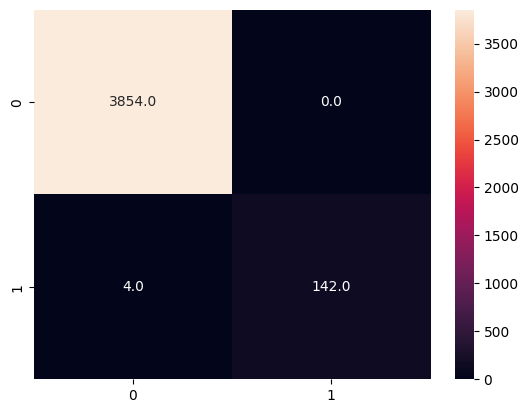

In [89]:
y_hat = best_clf.predict(X_test)
cn = confusion_matrix(y_test,y_hat)

sns.heatmap(cn,annot=True,fmt=".1f")
plt.show()


In [90]:
# lets do it on the whole dataset 
X = df_preprocessed[[col for col in df_preprocessed.columns if col not in ['remainder__ClaimAmount','remainder__Y']]].values
Y = df_preprocessed.remainder__Y.values

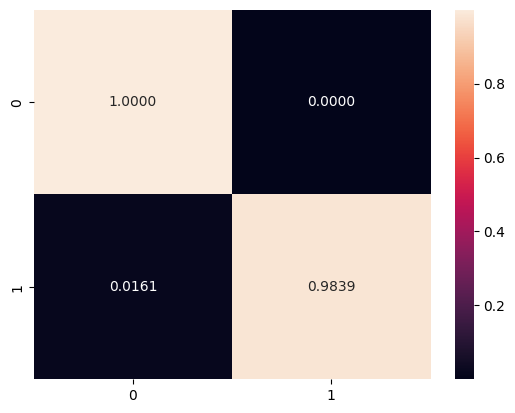

In [94]:
y_hat = best_clf.predict(X)
cn = confusion_matrix(Y,y_hat,normalize="true")

sns.heatmap(cn,annot=True,fmt=".4f")
plt.show()


In [95]:
from sklearn.metrics import f1_score

In [99]:
f1_score(Y,y_hat,average="macro")

0.9955407688858389

In [ ]:
best_clf.

In [107]:
df_preprocessed.columns

Index(['one-hot-encoding__VehGas_Diesel', 'one-hot-encoding__VehGas_Regular',
       'one-hot-encoding__Region_R11', 'one-hot-encoding__Region_R21',
       'one-hot-encoding__Region_R22', 'one-hot-encoding__Region_R23',
       'one-hot-encoding__Region_R24', 'one-hot-encoding__Region_R25',
       'one-hot-encoding__Region_R26', 'one-hot-encoding__Region_R31',
       'one-hot-encoding__Region_R41', 'one-hot-encoding__Region_R42',
       'one-hot-encoding__Region_R43', 'one-hot-encoding__Region_R52',
       'one-hot-encoding__Region_R53', 'one-hot-encoding__Region_R54',
       'one-hot-encoding__Region_R72', 'one-hot-encoding__Region_R73',
       'one-hot-encoding__Region_R74', 'one-hot-encoding__Region_R82',
       'one-hot-encoding__Region_R83', 'one-hot-encoding__Region_R91',
       'one-hot-encoding__Region_R93', 'one-hot-encoding__Region_R94',
       'one-hot-encoding__Area_A', 'one-hot-encoding__Area_B',
       'one-hot-encoding__Area_C', 'one-hot-encoding__Area_D',
       'one-hot

<Axes: >

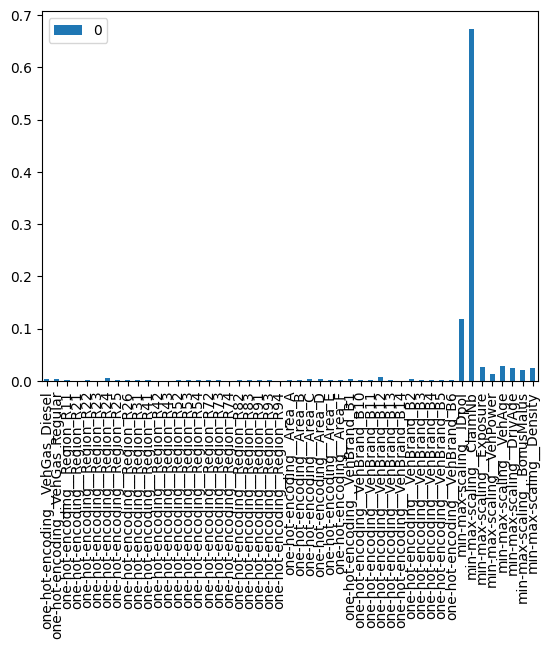

In [112]:
pd.DataFrame(best_clf
             .feature_importances_
             ,index=[col for col in df_preprocessed.columns if col not in ['remainder__ClaimAmount','remainder__Y']]).plot(kind="bar")

### well, guess I am done 